In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix


import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout      # create layers
from keras.metrics import CategoricalAccuracy, Recall, Precision, AUC
from keras.backend import clear_session


import os
import sys
sys.path.append("..")
from src.data.preprocessing import load_preprocess_data
from src.features.feature_engineering import create_features, unwrap_smart_7

# Read Data

In [2]:
# read data
repo_path = os.getcwd() + "/../"
df_source = load_preprocess_data(path=repo_path)
df = create_features(df_source, interval=30, trigger_percentage=0.05)
df = unwrap_smart_7(df)

  0%|          | 0/608 [00:00<?, ?it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
100%|██████████| 608/608 [00:12<00:00, 47.13it/s]


# Check Duplicates

In [3]:
serials_failed = df_source.query("failure == 1")["serial_number"].to_list()
serials_failed_unique = set(serials_failed)
print("Number of failed days:", len(serials_failed))
print("Number of unique serial number on the failed day:", len(serials_failed_unique))
tmp = serials_failed[:]
for serial in serials_failed_unique:
    tmp.remove(serial)

if len(tmp) == 0:
    print("There is no duplicate")
else:
    print(f"There {len(tmp)} duplicates")
    print("   duplicated serial numbers",tmp)
    df.drop(298155, inplace=True)
    df.drop(309081, inplace=True)
    df.reset_index(inplace=True)
    print("Number of rows before drop:", len(df_source))
    print("Number of rows after drop:", len(df))   

Number of failed days: 610
Number of unique serial number on the failed day: 608
There 2 duplicates
   duplicated serial numbers ['Z302SQFX', 'Z303VDR4']
Number of rows before drop: 462966
Number of rows after drop: 462964


# Create Target and Features

In [4]:
def get_smart_999_accumulated(df_in):
    df_tmp = df_in.drop(["index"], axis=1).copy()
    serials = df_tmp['serial_number'].unique()
    #serials = serials[0:2]
    #print(serials)
    for i, serial in enumerate(serials):
        df_serial = df_tmp.query('serial_number == @serial').sort_values(by='date').reset_index(drop=True)
        df_serial['smart_999_accumulated'] = df_serial['smart_999'].cumsum()
        if i == 0:
            df = df_serial.copy()
        else:
            df = pd.concat([df, df_serial], ignore_index=True)
    return df

In [5]:
# select features
"""
cols = ['date', 'serial_number', 'model', 'failure', 'smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'countdown','smart_999']
df = df[pd.Index(cols)]
"""

# create smart_999_accumulated
df = get_smart_999_accumulated(df)

# create target
df['failure_in_30_days'] = df['countdown'].apply(lambda x : 1 if x <= 30 else 0)
df.head(5)

,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,...,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999,smart_999_accumulated,failure_in_30_days
0,2019-01-01,Z304JG86,ST4000DM000,0,168829568.0,10.0,0.0,257899631.0,27368.0,10.0,...,False,False,False,False,False,False,False,0,0,0
1,2019-01-02,Z304JG86,ST4000DM000,0,50913560.0,10.0,0.0,259688596.0,27392.0,10.0,...,False,False,False,False,False,False,False,0,0,0
2,2019-01-03,Z304JG86,ST4000DM000,0,176805800.0,10.0,0.0,261018343.0,27416.0,10.0,...,False,False,False,False,False,False,False,0,0,0
3,2019-01-04,Z304JG86,ST4000DM000,0,217666344.0,10.0,0.0,261751900.0,27440.0,10.0,...,False,False,False,False,False,False,False,0,0,0
4,2019-01-05,Z304JG86,ST4000DM000,0,218092400.0,10.0,0.0,263166092.0,27464.0,10.0,...,False,False,False,False,False,False,False,0,0,0


# Split Data

In [6]:
# split data
RSEED = 200
serial_train, serial_test, dummy1, dummy2 = train_test_split(df['serial_number'].unique(), df['serial_number'].unique(), test_size=0.3, random_state=RSEED)
df_train = df[df['serial_number'].isin(serial_train)]
df_test = df[df['serial_number'].isin(serial_test)]

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())

number of unique disk in data: 608
number of unique disk in train: 425
number of unique disk in test: 183


In [7]:
df.columns

Index(['date', 'serial_number', 'model', 'failure', 'smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'date_failure', 'countdown', 'smart_7_mod', 'smart_1_raw_ema',
       'smart_4_raw_ema', 'smart_5_raw_ema', 'smart_7_raw_ema',
       'smart_9_raw_ema', 'smart_12_raw_ema', 'smart_183_raw_ema',
       'smart_184_raw_ema', 'smart_187_raw_ema', 'smart_188_raw_ema',
       'smart_189_raw_ema', 'smart_190_raw_ema', 'smart_192_raw_ema',
       'smart_193_raw_ema', 'smart_194_raw_ema', 'smart_197_raw_ema',
       'smart_198_raw_ema', 'smart_199_raw_ema', 'smart_240_raw_ema',
       'smart_241_raw_ema', 'smart_242_raw_ema', 'smart_7_mod_ema',
       'smart_4_ra

# Set X and y

In [8]:
# set X and y

cols_feature = [
    'smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
    'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
    'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
    'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
    'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
    'smart_999', 'smart_999_accumulated']

"""
cols_feature =['smart_1_raw',
       'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
       'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_189_raw', 'smart_190_raw', 'smart_192_raw',
       'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'smart_999', 'smart_999_accumulated',
       'smart_4_raw_trigger', 'smart_5_raw_trigger', 'smart_12_raw_trigger',
       'smart_183_raw_trigger', 'smart_184_raw_trigger',
       'smart_187_raw_trigger', 'smart_188_raw_trigger',
       'smart_189_raw_trigger', 'smart_193_raw_trigger',
       'smart_192_raw_trigger', 'smart_197_raw_trigger',
       'smart_198_raw_trigger', 'smart_199_raw_trigger']
"""

X_train = df_train[cols_feature]
y_train = df_train['failure_in_30_days']

X_test = df_test[cols_feature]
y_test = df_test['failure_in_30_days']

# Log and Scale

In [9]:
# log 
X_train_log = X_train.apply(lambda x : np.log10(x+1))
X_test_log = X_test.apply(lambda x : np.log10(x+1))

# scale
scaler = MinMaxScaler()
scaler.fit(X_train_log)

X_train_log_scaled = pd.DataFrame(scaler.transform(X_train_log), columns=X_train_log.columns)
X_test_log_scaled = pd.DataFrame(scaler.transform(X_test_log), columns=X_test_log.columns)
X_train_log_scaled.describe()

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_mod,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_999,smart_999_accumulated
count,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,...,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000
mean,0.948199,0.466722,0.021088,0.426622,0.718608,0.454216,0.079295,0.002513,0.086623,0.004006,...,0.585701,0.276540,0.040259,0.040259,0.006770,0.716817,0.804220,0.405489,0.062580,0.384096
std,0.052070,0.135096,0.105555,0.041251,0.120544,0.135439,0.147114,0.037659,0.177416,0.041590,...,0.139954,0.097144,0.109661,0.109661,0.065471,0.121230,0.103178,0.135249,0.173086,0.304674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.928456,0.372090,0.000000,0.403457,0.632733,0.366339,0.000000,0.000000,0.000000,0.000000,...,0.524689,0.202956,0.000000,0.000000,0.000000,0.630340,0.768032,0.297732,0.000000,0.000000
50%,0.964183,0.457565,0.000000,0.428695,0.721273,0.450492,0.000000,0.000000,0.000000,0.000000,...,0.574272,0.270698,0.000000,0.000000,0.000000,0.719323,0.822085,0.398433,0.000000,0.454041
75%,0.985110,0.540813,0.000000,0.449477,0.809351,0.532453,0.166946,0.000000,0.000000,0.000000,...,0.627316,0.349349,0.000000,0.000000,0.000000,0.808123,0.868006,0.498544,0.000000,0.636346
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Function for Printing Metrics

In [10]:
def show_metrics(y_train, y_train_pred, y_test, y_test_pred, digit=20):
    for data in ["train", "test"]:
        print("=======================================")
        print(f"# For {data} data:")
        if data == "train":
            y_true = y_train
            y_pred = y_train_pred
        else:
            y_true = y_test
            y_pred = y_test_pred
        f2 = fbeta_score(y_true, y_pred, beta=2)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        print("  f2-score  :", (f2*100).round(digit), "%")
        print("  precision :", (pre*100).round(digit), "%")
        print("  recall    :", (rec*100).round(digit), "%")
        print("  accuracy  :", (acc*100).round(digit), "%")

    fig, axes = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle("Confusion Matrix")
    for i in range(4):
        if i//2 == 0:
            train_or_test = "Train"
            y_true = y_train
            y_pred = y_train_pred
        else:
            train_or_test = "Test"
            y_true = y_test
            y_pred = y_test_pred
        if i%2 == 0:
            scale = " (log scale)"
            data = np.log10(confusion_matrix(y_true, y_pred))
        else:
            data = confusion_matrix(y_true, y_pred)
            scale = ""
        sns.heatmap(data, annot=True, ax=axes[i//2, i%2])
        axes[i//2,i%2].set_title(f"{train_or_test}{scale}")
        axes[i//2,i%2].set_ylabel("Truth", fontsize=25)
        axes[i//2,i%2].set_xlabel("Prediction", fontsize=25)

    fig.tight_layout()
    plt.show()

def show_roc_curve(y_train, y_train_score, y_test, y_test_score):
    RocCurveDisplay.from_predictions(y_train, y_train_score)
    RocCurveDisplay.from_predictions(y_test, y_test_score)


# Neural Network

Check again the shape and features in X:

In [11]:
print(X_train.shape)
X_train.columns

(327346, 23)


Index(['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_mod',
       'smart_9_raw', 'smart_12_raw', 'smart_183_raw', 'smart_184_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_189_raw', 'smart_190_raw',
       'smart_192_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw',
       'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw',
       'smart_242_raw', 'smart_999', 'smart_999_accumulated'],
      dtype='object')

Construct layers and compile:

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-21 17:00:14.251562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-21 17:00:14.251844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                360       
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 616
Trainable params: 616
Non-trainable params: 0
_________________________________________________________________
None


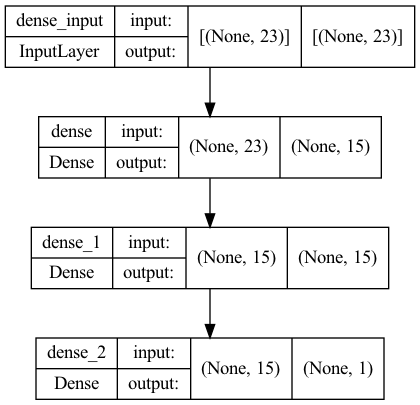

In [12]:
# clear session after repeated runs
clear_session()

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['AUC', 'Recall', 'Precision', 'accuracy'])
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True, dpi=96)

Train the network:

Epoch 1/100


2022-03-21 17:00:15.152323: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-21 17:00:15.950654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/14 [==========================>...] - ETA: 0s - loss: 2.8750 - auc: 0.5092 - recall: 1.0000 - precision: 0.0355 - accuracy: 0.0355

2022-03-21 17:00:17.552512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 3s 117ms/step - loss: 2.8722 - auc: 0.5088 - recall: 1.0000 - precision: 0.0355 - accuracy: 0.0355 - val_loss: 0.7036 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.0597 - val_accuracy: 0.0597
Epoch 2/100
14/14 [==============================] - 1s 80ms/step - loss: 2.8325 - auc: 0.5544 - recall: 1.0000 - precision: 0.0355 - accuracy: 0.0355 - val_loss: 0.7239 - val_auc: 0.7135 - val_recall: 1.0000 - val_precision: 0.0597 - val_accuracy: 0.0597
Epoch 3/100
14/14 [==============================] - 1s 58ms/step - loss: 2.7487 - auc: 0.6243 - recall: 1.0000 - precision: 0.0355 - accuracy: 0.0355 - val_loss: 0.7662 - val_auc: 0.7233 - val_recall: 1.0000 - val_precision: 0.0597 - val_accuracy: 0.0597
Epoch 4/100
14/14 [==============================] - 0s 29ms/step - loss: 2.5931 - auc: 0.6845 - recall: 1.0000 - precision: 0.0355 - accuracy: 0.0355 - val_loss: 0.8493 - val_auc: 0.7967 - val_recall: 1.0000 - val_precision: 0.0597 - val_accu

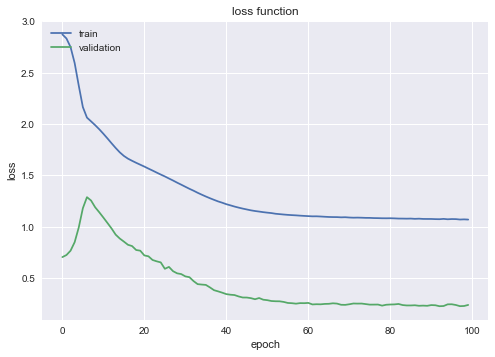

2022-03-21 17:00:44.284552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# For train data:
  f2-score  : 35.30869365598077 %
  precision : 10.976198472000672 %
  recall    : 79.2048466489966 %
  accuracy  : 73.24696193019007 %
# For test data:
  f2-score  : 35.717805519053876 %
  precision : 11.346796075975787 %
  recall    : 77.13728272437035 %
  accuracy  : 73.9946024863956 %


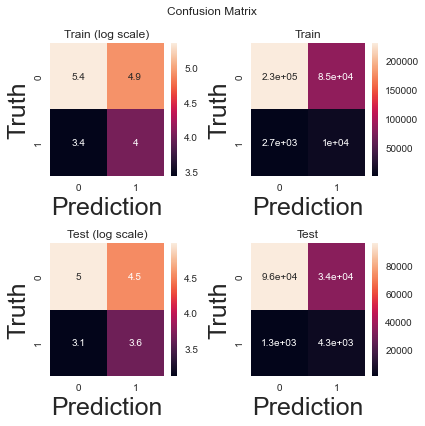

In [13]:
# Train the ANN
#training = model.fit(X_train, y_train, batch_size = 10000, validation_split=0.2, epochs = 100, class_weight={0:1.0, 1:1000.0})
training = model.fit(X_train_log_scaled, y_train, batch_size = 20000, validation_split=0.2, epochs = 100, class_weight={0:1.0, 1:90.0})

# summarize history for accuracy
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# prediction
y_train_pred = model.predict(X_train_log_scaled)
y_test_pred = model.predict(X_test_log_scaled)

# evaluate metrics
show_metrics(y_train, y_train_pred.round(), y_test, y_test_pred.round(), digit=20)

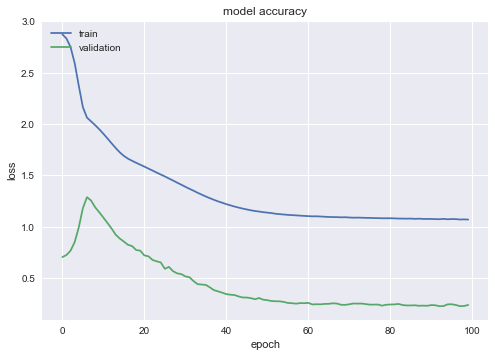

In [14]:
# summarize history for accuracy
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.ylim(0,2.4)
plt.show()

array([[0.00894905],
       [0.00997423],
       [0.00854293],
       ...,
       [0.3512105 ],
       [0.27927002],
       [0.28522384]], dtype=float32)

[[0.00968239]
 [0.00961098]
 [0.0096731 ]
 ...
 [0.07776736]
 [0.07736649]
 [0.2673844 ]]


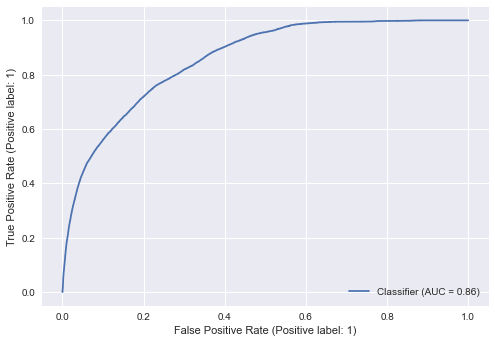

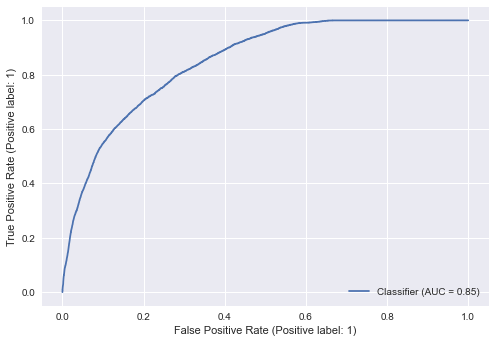

In [17]:
print(y_test_pred)
show_roc_curve(y_train, y_train_pred, y_test, y_test_pred)